In [1]:
import os 
import numpy as np 
import math
from scipy.stats import linregress

from NirsLabProject.config.consts import *
from NirsLabProject.utils import pipeline_utils as putils
from NirsLabProject.utils import sleeping_utils
from NirsLabProject.utils import general_utils as utils
from NirsLabProject.config.subject import Subject
from NirsLabProject.utils import plotting


In [3]:
subjects_stats = {
    TIMESTAMP_INDEX: {},
    AMPLITUDE_INDEX: {},
    DURATION_INDEX: {},
    ANGLE_INDEX: {},
    RELATIVE_SPIKE_AMPLITUDE_INDEX: {},
    RELATIVE_SPIKE_DURATION_INDEX: {},
    GROUP_FOCAL_AMPLITUDE_INDEX: {},
    GROUP_EVENT_DURATION_INDEX: {},
    GROUP_EVENT_SIZE_INDEX: {},
    GROUP_EVENT_SPATIAL_SPREAD_INDEX: {},
    GROUP_EVENT_DEEPEST_INDEX: {},
    GROUP_EVENT_SHALLOWEST_INDEX: {},
}

feature_id_to_title = {
    TIMESTAMP_INDEX: 'Spike Rate Average',
    AMPLITUDE_INDEX: 'Spike Amplitude Average',
    DURATION_INDEX: 'Spike Width Average',
    ANGLE_INDEX: "Spike Angle",
    RELATIVE_SPIKE_AMPLITUDE_INDEX: 'Spike Relative Amplitude',
    RELATIVE_SPIKE_DURATION_INDEX: 'Spike Relative Width',
    GROUP_FOCAL_AMPLITUDE_INDEX: 'Spike Group Focal Amplitude',
    GROUP_EVENT_DURATION_INDEX: 'Spike Group Event Duration Average',
    GROUP_EVENT_SIZE_INDEX: 'Spike Group Event Size Average',
    GROUP_EVENT_SPATIAL_SPREAD_INDEX: 'Spike Group Event Spatial Spread Average',
    GROUP_EVENT_DEEPEST_INDEX: 'Spike Group Event Deepest Electrode Avrage',
    GROUP_EVENT_SHALLOWEST_INDEX: 'Spike Group Event Shallowest Electrode Avrage',
}

stimuli_subjects = putils.get_subjects(
    filters=[
        lambda subj: subj.stimuli_project,
        lambda subj: os.path.exists(subj.paths.subject_flat_features_path),
        lambda subj: subj.p_number not in [515]
    ],
    sort_key=lambda subj: subj.p_number,
)
subjects = {
    s: s for s in stimuli_subjects
}

nrem_subjects_blocks = {}
subjects_blocks = {}
subject_block_durations = {}
for subj, stimuli_subjects in subjects.items():
    block_durations = putils.get_blocks_duration(subj)
    subject_block_durations[subj] = {
        'before window': block_durations[0],
        'stim block': block_durations[1],
        'pause block': block_durations[2],
        'after window': block_durations[4],
    }
    
    if subj == stimuli_subjects:
        if os.path.exists(subj.paths.subject_sleep_scoring_path):
            nrem_data_of_blocks = putils.get_stimuli_subject_blocks(subj, only_nrem=True)
            data_of_blocks = putils.get_stimuli_subject_blocks(subj, only_nrem=False)
        else:
            print(f'stimuli {subj.p_number}')
            continue
    else:
        print(f'control {subj.p_number} with {stimuli_subjects.p_number}')
        if os.path.exists(subj.paths.subject_hypnogram_path):
            nrem_data_of_blocks = get_control_subject_blocks(subj, stimuli_subjects, only_nrem=True)
            data_of_blocks = get_control_subject_blocks(subj, stimuli_subjects, only_nrem=False)
        else:
            continue
    nrem_subjects_blocks[subj] = nrem_data_of_blocks
    subjects_blocks[subj] = data_of_blocks

# block_names = ['before window', 'stim block', 'pause block', 'after window']
block_names = ['pause block', 'stim block']


Calculating stimuli effects for subject 485
Calculating stimuli effects for subject 485
Calculating stimuli effects for subject 485
Calculating stimuli effects for subject 485
Calculating stimuli effects for subject 485
Calculating stimuli effects for subject 485
Calculating stimuli effects for subject 486
Calculating stimuli effects for subject 486
Calculating stimuli effects for subject 486
Calculating stimuli effects for subject 486
Calculating stimuli effects for subject 486
Calculating stimuli effects for subject 486
Calculating stimuli effects for subject 487
Calculating stimuli effects for subject 487
Calculating stimuli effects for subject 487
Calculating stimuli effects for subject 487
Calculating stimuli effects for subject 487
Calculating stimuli effects for subject 487
Calculating stimuli effects for subject 488
Calculating stimuli effects for subject 488
Calculating stimuli effects for subject 488
Calculating stimuli effects for subject 488
Calculating stimuli effects for 

In [4]:
def is_group_valid(group):
    for block_name, block_value in group.items():
        if not np.isnan(block_value):
            return True
    return False

## Seperators

In [18]:
def temporal_frontal_seperator(block_features, subj, feature_index):
        groups = ['temporal', 'frontal']
        frontal_chans = ['ROF', 'LOF', 'RAC', 'LAC', 'LAF', 'RAF', 'RFA', 'RIF-dAC', 'LOPR']
        temporal_chans = ['RA', 'LA', 'RAH', 'LAH', 'RMH', 'LMH', 'REC', 'LEC', 'RPHG', 'LPHG']
        index_to_channel_name = np.load(subj.paths.subject_channel_name_to_index_path, allow_pickle=True).item()
        channel_name_to_index = {channel_name: index for index, channel_name in index_to_channel_name.items()}
        frontal_chans = [channel_name_to_index[f'{chan}{i}'] for i in range(1,8) for chan in frontal_chans if f'{chan}{i}' in channel_name_to_index]
        temporal_chans = [channel_name_to_index[f'{chan}{i}'] for i in range(1,8) for chan in temporal_chans if f'{chan}{i}' in channel_name_to_index]

        
        frontal_manes = {
            block_name: np.mean(features[np.where(np.isin(features[:, CHANNEL_INDEX], frontal_chans))][:, feature_index])
            for block_name, features in block_features.items() if features is not None
        }
        
        frontal_counts = {
            block_name: features[np.where(np.isin(features[:, CHANNEL_INDEX], frontal_chans))][:, feature_index].shape[0]
            for block_name, features in block_features.items() if features is not None
        }
        
        temporal_manes = {
            block_name: np.mean(features[np.where(np.isin(features[:, CHANNEL_INDEX], temporal_chans))][:, feature_index])
            for block_name, features in block_features.items() if features is not None
        } 
        
        temporal_counts = {
            block_name: features[np.where(np.isin(features[:, CHANNEL_INDEX], temporal_chans))][:, feature_index].shape[0]
            for block_name, features in block_features.items() if features is not None
        } 
        
        means = {
            groups[0]: temporal_manes,
            groups[1]: frontal_manes,
        }
        
        counts =  {
            groups[0]: temporal_counts,
            groups[1]: frontal_counts,
        }
        
        return groups, means, counts
    
def nrem_seperator(block_features, subj, feature_index):
        groups = ['NREM', 'REM/Wake']
        nrem_mean = {
            block_name: np.mean(features[features[:, HYPNOGRAM_FLAG_INDEX] == HYPNOGRAM_FLAG_NREM][:, feature_index])
            for block_name, features in block_features.items() if features is not None
        }
        
        rest_mean = {
            block_name: np.mean(features[features[:, HYPNOGRAM_FLAG_INDEX] != HYPNOGRAM_FLAG_NREM][:, feature_index])
            for block_name, features in block_features.items() if features is not None
        } 
        
        means = {
            groups[0]: nrem_mean,
            groups[1]: rest_mean,
        }
        
        nrem_count = {
            block_name: features[features[:, HYPNOGRAM_FLAG_INDEX] == HYPNOGRAM_FLAG_NREM][:, feature_index].shape[0]
            for block_name, features in block_features.items() if features is not None
        }
        
        rest_count = {
            block_name: features[features[:, HYPNOGRAM_FLAG_INDEX] != HYPNOGRAM_FLAG_NREM][:, feature_index].shape[0]
            for block_name, features in block_features.items() if features is not None
        } 
        
        counts = {
            groups[0]: nrem_count,
            groups[1]: rest_count,
        }
        
        return groups, means, counts
    

def temporal_frontal_soze(block_features, subj, feature_index):
    groups = ['temporal', 'frontal']
    temporal_soz = [485, 487, 488, 496, 497, 498, 515, 520, 544]
    frontal_soz = [486, 499, 505, 5101, 5107]

    temporal_manes = {
        block_name: np.mean(features[np.where(np.isin(features[:, SUBJECT_NUMBER], temporal_soz))][:, feature_index])
        for block_name, features in block_features.items() if features is not None
    } 

    temporal_counts = {
        block_name: features[np.where(np.isin(features[:, SUBJECT_NUMBER], temporal_soz))][:, feature_index].shape[0] or np.nan
        for block_name, features in block_features.items() if features is not None
    } 

    frontal_manes = {
        block_name: np.mean(features[np.where(np.isin(features[:, SUBJECT_NUMBER], frontal_soz))][:, feature_index])
        for block_name, features in block_features.items() if features is not None
    }

    frontal_counts = {
        block_name: features[np.where(np.isin(features[:, SUBJECT_NUMBER], frontal_soz))][:, feature_index].shape[0] or np.nan
        for block_name, features in block_features.items() if features is not None
    }

    means = {
        groups[0]: temporal_manes,
        groups[1]: frontal_manes,
    }

    counts =  {
        groups[0]: temporal_counts,
        groups[1]: frontal_counts,
    }

    return groups, means, counts

def contra_ipsi_inter_subjects_seperator(block_features, subj, feature_index):
    groups = ['contra', 'ipsi']
    contra_stim = [486, 487, 488, 489, 498, 499, 5101, 5107, 538, 544]
    ipsi_stim = [485, 496, 505, 515]

    contra_manes = {
        block_name: np.mean(features[np.where(np.isin(features[:, SUBJECT_NUMBER], contra_stim))][:, feature_index])
        for block_name, features in block_features.items() if features is not None
    } 

    contra_counts = {
        block_name: features[np.where(np.isin(features[:, SUBJECT_NUMBER], contra_stim))][:, feature_index].shape[0] or np.nan
        for block_name, features in block_features.items() if features is not None
    } 

    ipsi_manes = {
        block_name: np.mean(features[np.where(np.isin(features[:, SUBJECT_NUMBER], ipsi_stim))][:, feature_index])
        for block_name, features in block_features.items() if features is not None
    }

    ipsi_counts = {
        block_name: features[np.where(np.isin(features[:, SUBJECT_NUMBER], ipsi_stim))][:, feature_index].shape[0] or np.nan
        for block_name, features in block_features.items() if features is not None
    }

    means = {
        groups[0]: contra_manes,
        groups[1]: ipsi_manes,
    }

    counts =  {
        groups[0]: contra_counts,
        groups[1]: ipsi_counts,
    }

    return groups, means, counts

def contra_ipsi_seperator(block_features, subj, feature_index):
    groups = ['contra', 'ipsi']
    stim_side_right = [485, 487, 489, 490, 496, 497, 5101, 5107, 515, 520, 538, 544, 545]
    stim_side = 'R' if subj.p_number in stim_side_right else 'L'
    
    index_to_channel_name = np.load(subj.paths.subject_channel_name_to_index_path, allow_pickle=True).item()
        
    contra_chans = [i for i, n in index_to_channel_name.items() if n[0] != stim_side]
    ipsi_chans = [i for i, n in index_to_channel_name.items() if n[0] == stim_side]
    
    contra_manes = {
            block_name: np.mean(features[np.where(np.isin(features[:, CHANNEL_INDEX], contra_chans))][:, feature_index])
            for block_name, features in block_features.items() if features is not None
    }

    contra_counts = {
        block_name: features[np.where(np.isin(features[:, CHANNEL_INDEX], contra_chans))][:, feature_index].shape[0]
        for block_name, features in block_features.items() if features is not None
    }

    ipsi_manes = {
        block_name: np.mean(features[np.where(np.isin(features[:, CHANNEL_INDEX], ipsi_chans))][:, feature_index])
        for block_name, features in block_features.items() if features is not None
    } 

    ipsi_counts = {
        block_name: features[np.where(np.isin(features[:, CHANNEL_INDEX], ipsi_chans))][:, feature_index].shape[0]
        for block_name, features in block_features.items() if features is not None
    } 

    means = {
        groups[0]: contra_manes,
        groups[1]: ipsi_manes,
    }

    counts =  {
        groups[0]: contra_counts,
        groups[1]: ipsi_counts,
    }

    return groups, means, counts

def mixed_synced_stimuli_seperator(block_features, subj, feature_index):
    groups = ['Mixed', 'Synced']
    mixed = [485, 497, 499, 505, 5101, 5107]
    for block_name, features in block_features.items():
        break
    
    mixed_manes = {
        block_name: np.mean(features[np.where(np.isin(features[:, SUBJECT_NUMBER], mixed))][:, feature_index])
        for block_name, features in block_features.items() if features is not None
    } 

    mixed_counts = {
        block_name: features[np.where(np.isin(features[:, SUBJECT_NUMBER], mixed))][:, feature_index].shape[0] or np.nan
        for block_name, features in block_features.items() if features is not None
    } 

    synced_manes = {
        block_name: np.mean(features[np.where(~np.isin(features[:, SUBJECT_NUMBER], mixed))][:, feature_index])
        for block_name, features in block_features.items() if features is not None
    }

    synced_counts = {
        block_name: features[np.where(~np.isin(features[:, SUBJECT_NUMBER], mixed))][:, feature_index].shape[0] or np.nan
        for block_name, features in block_features.items() if features is not None
    }

    means = {
        groups[0]: mixed_manes,
        groups[1]: synced_manes,
    }

    counts =  {
        groups[0]: mixed_counts,
        groups[1]: synced_counts,
    }
    return groups, means, counts


def all(block_features, subj, feature_index):
    groups = ['All']
    
    manes = {
        block_name: np.mean(features[:, feature_index])
        for block_name, features in block_features.items() if features is not None
    } 

    counts = {
        block_name: features[:, feature_index].shape[0] or np.nan
        for block_name, features in block_features.items() if features is not None
    } 

    means = {
        groups[0]: manes,
    }

    counts =  {
        groups[0]: counts,
    }
    return groups, means, counts

no data for 19 of p489
no data for 19 of p497
no data for 19 of p498
no data for 19 of p505
no data for 19 of p538
no data for 19 of p541
no data for 19 of p544
no data for 19 of p5101
no data for 19 of p5107
no data for 20 of p489
no data for 20 of p497
no data for 20 of p498
no data for 20 of p505
no data for 20 of p538
no data for 20 of p541
no data for 20 of p544
no data for 20 of p5101
no data for 20 of p5107
no data for 21 of p489
no data for 21 of p497
no data for 21 of p498
no data for 21 of p505
no data for 21 of p538
no data for 21 of p541
no data for 21 of p544
no data for 21 of p5101
no data for 21 of p5107
Skipping block stim block for subject p520
no data for 19 of p489
no data for 19 of p497
no data for 19 of p498
no data for 19 of p505
no data for 19 of p538
no data for 19 of p541
no data for 19 of p544
no data for 19 of p5101
no data for 19 of p5107
no data for 20 of p489
no data for 20 of p497
no data for 20 of p498
no data for 20 of p505
no data for 20 of p538
no dat

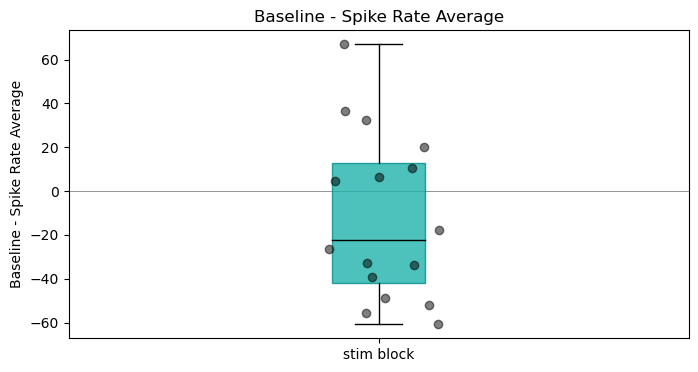

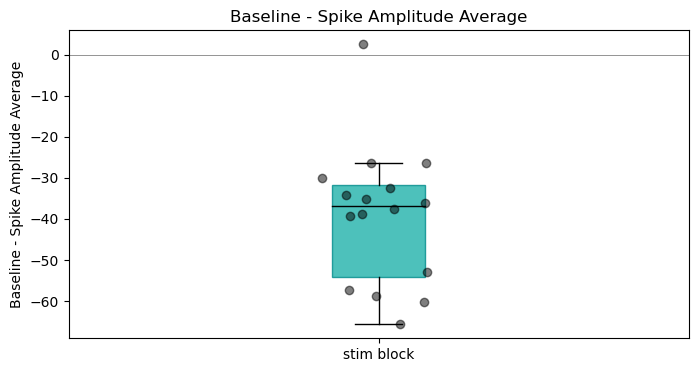

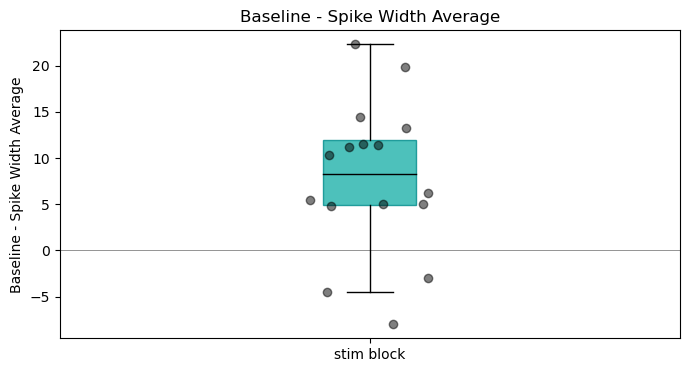

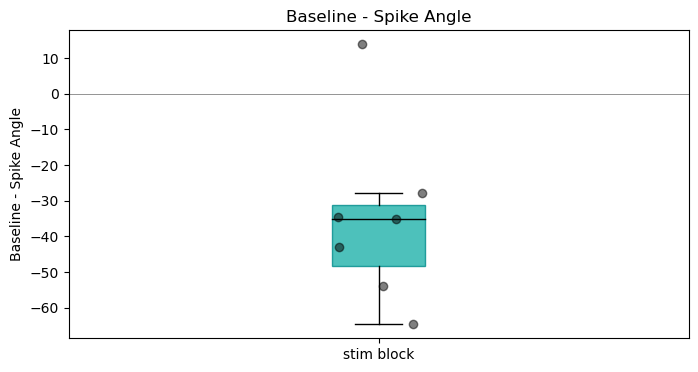

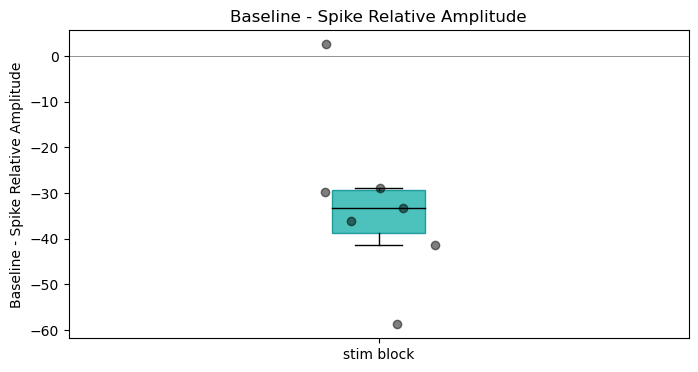

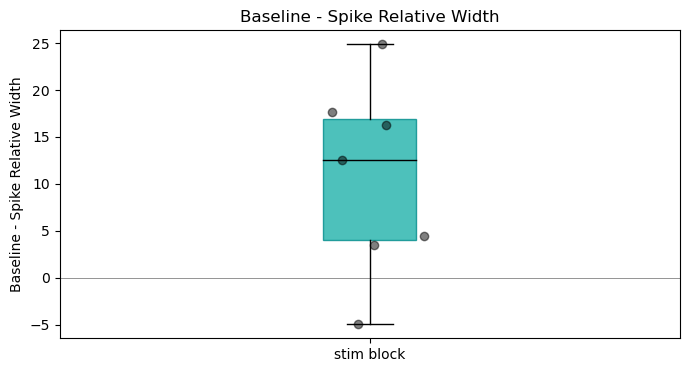

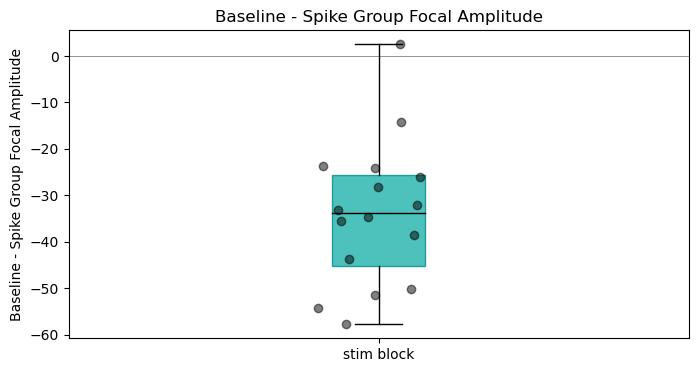

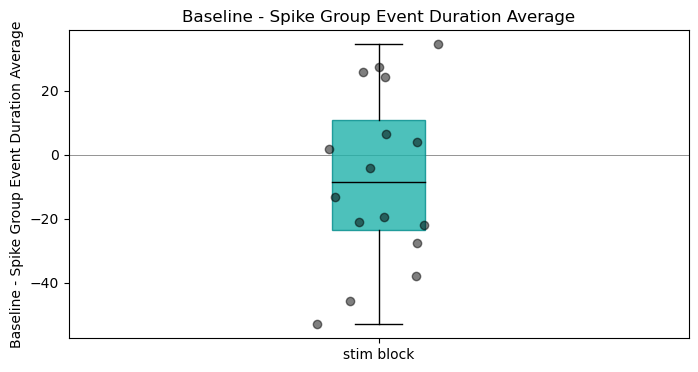

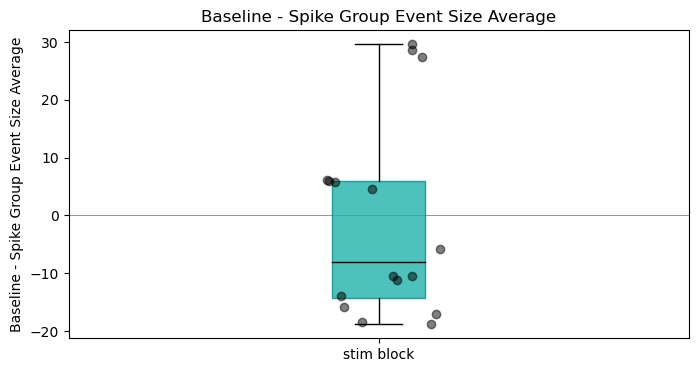

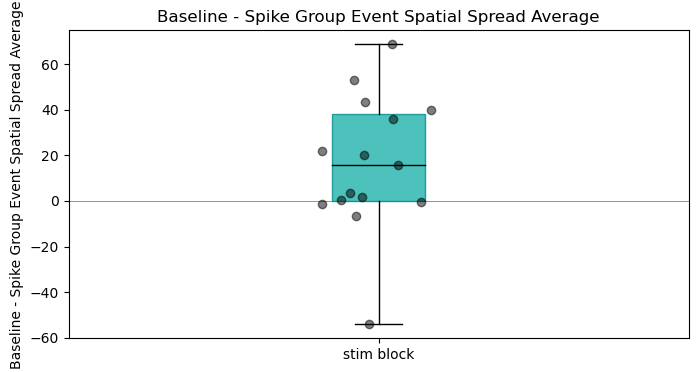

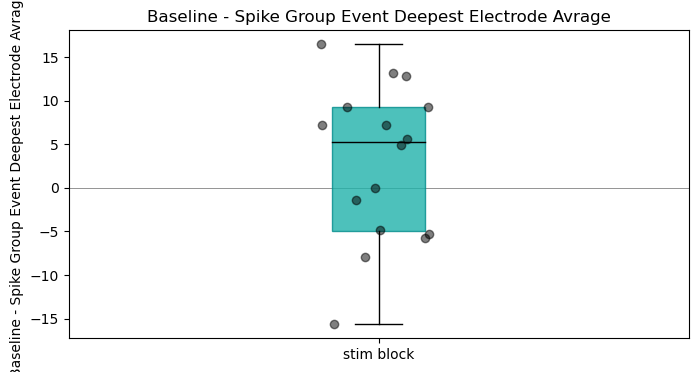

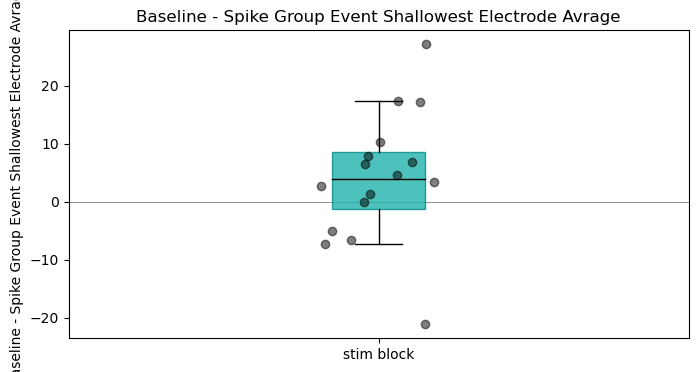

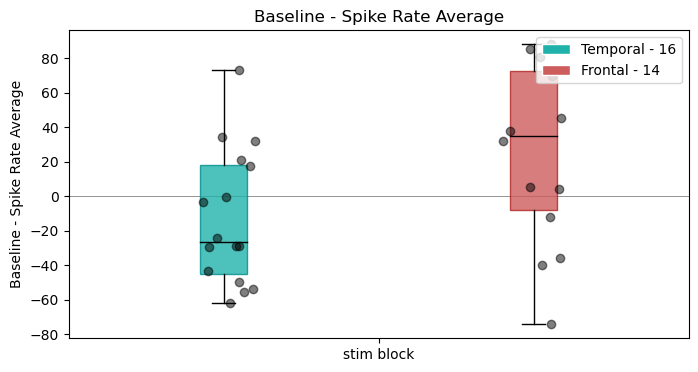

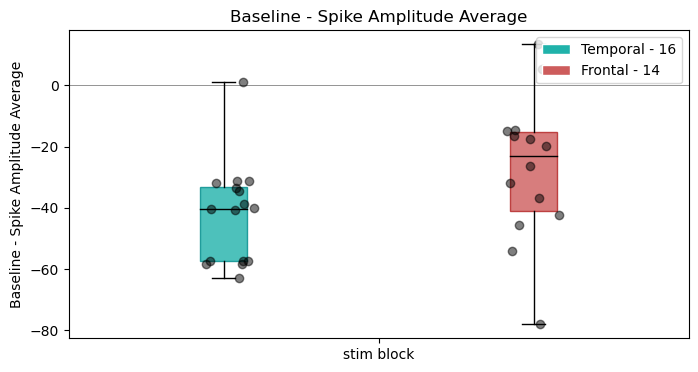

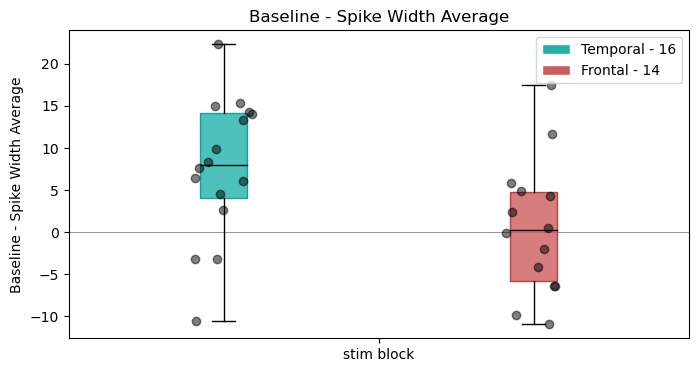

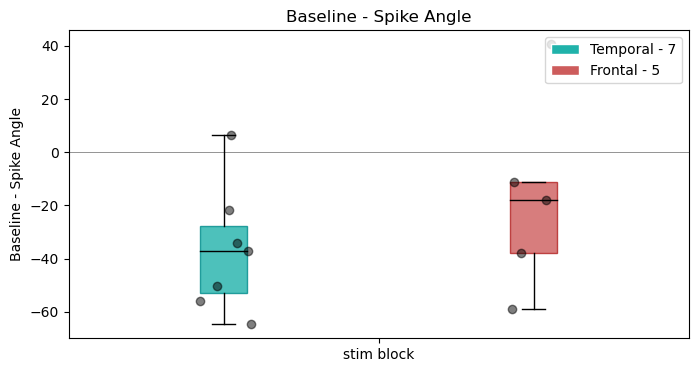

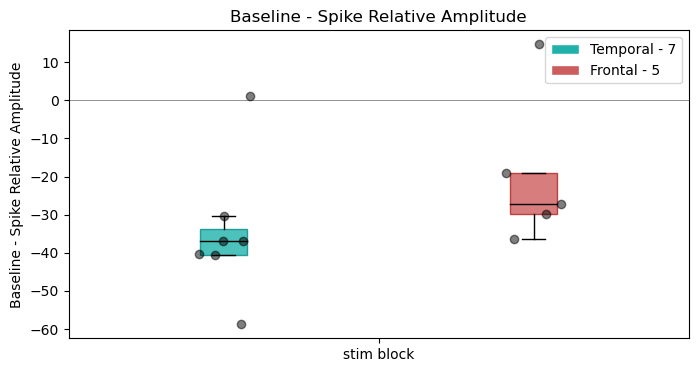

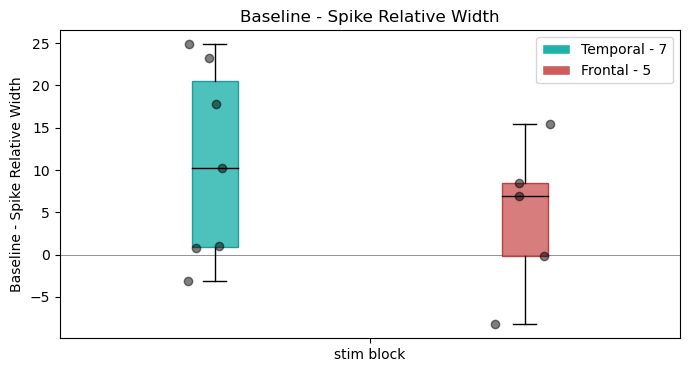

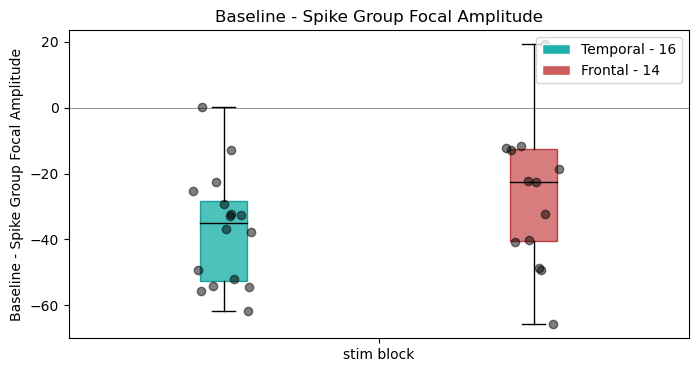

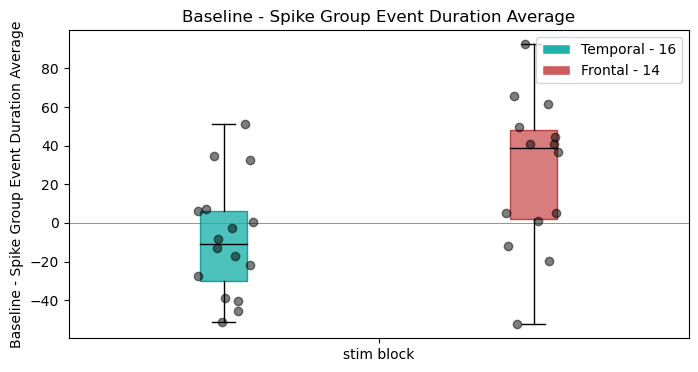

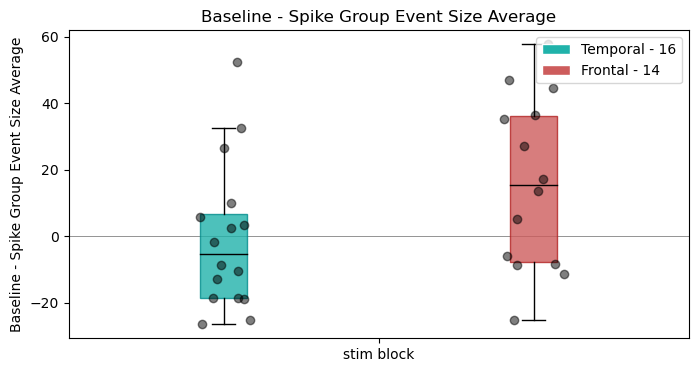

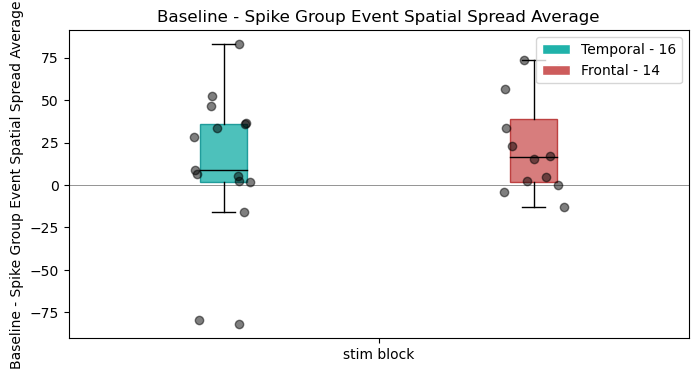

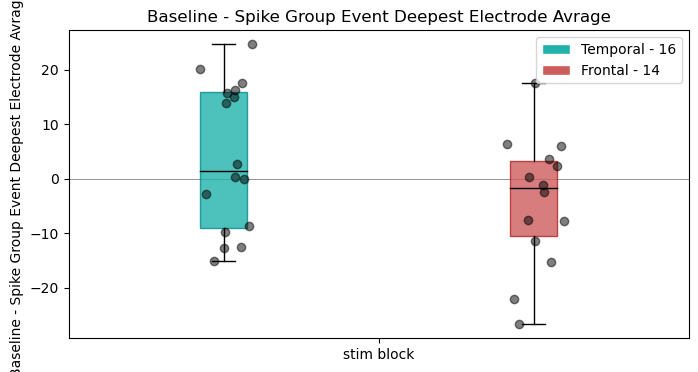

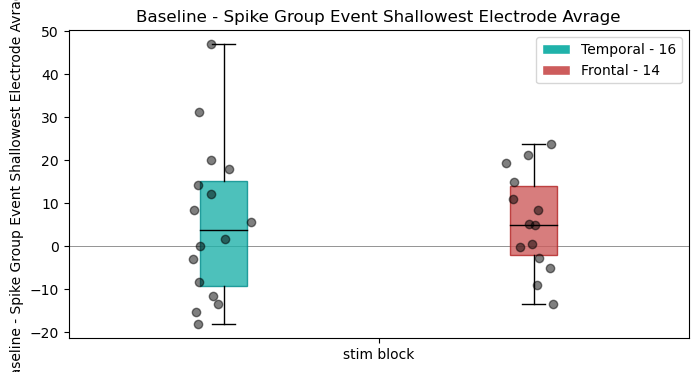

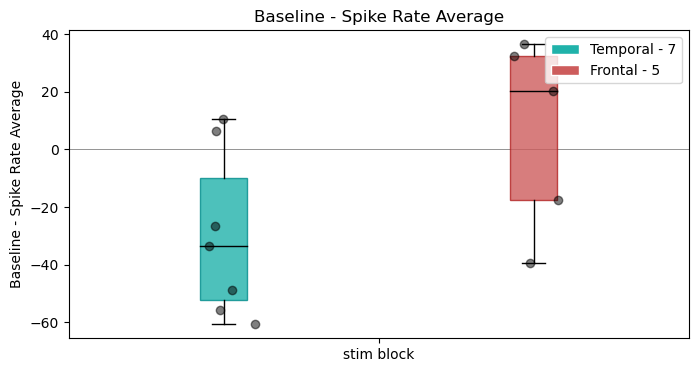

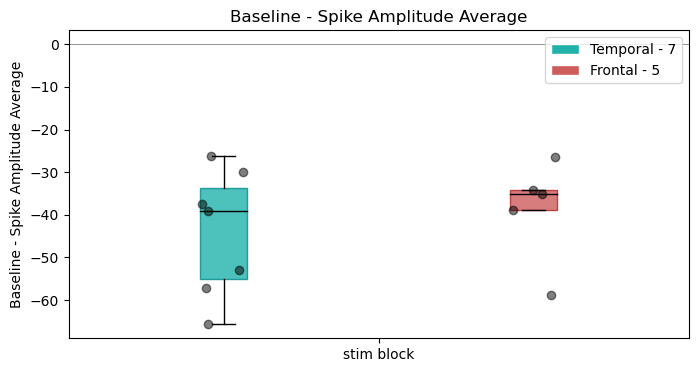

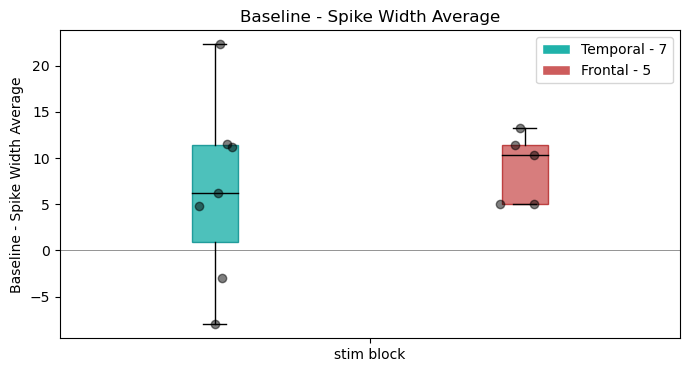

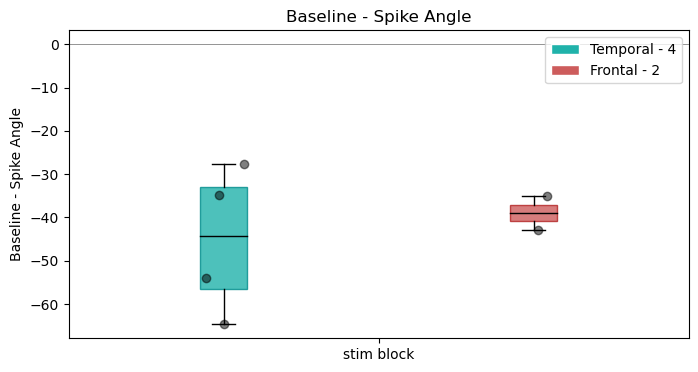

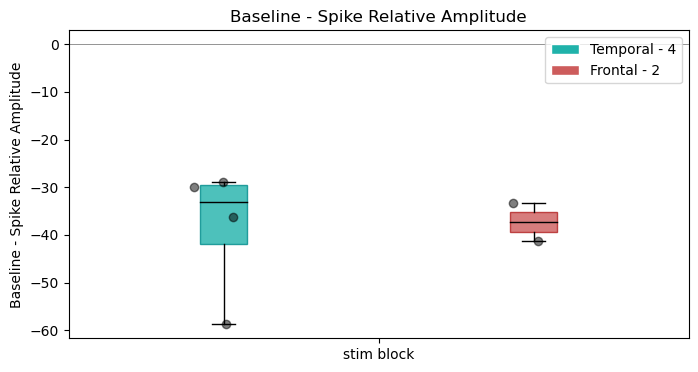

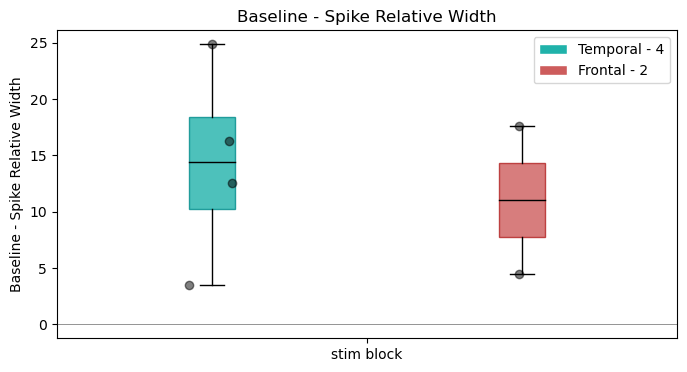

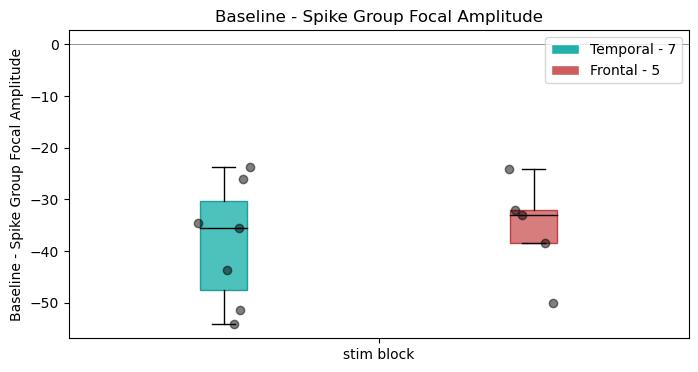

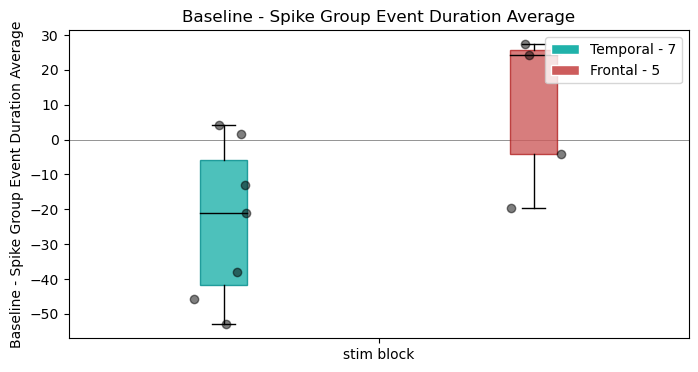

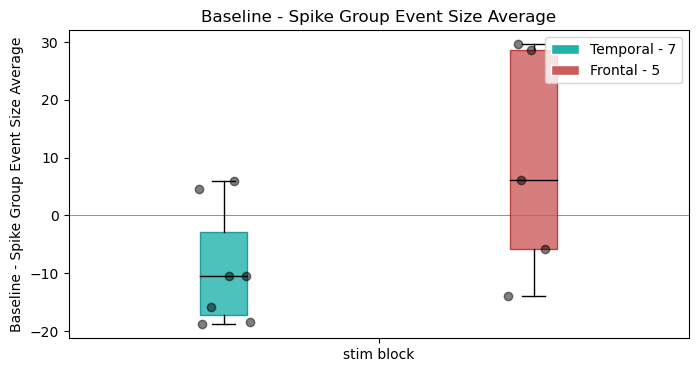

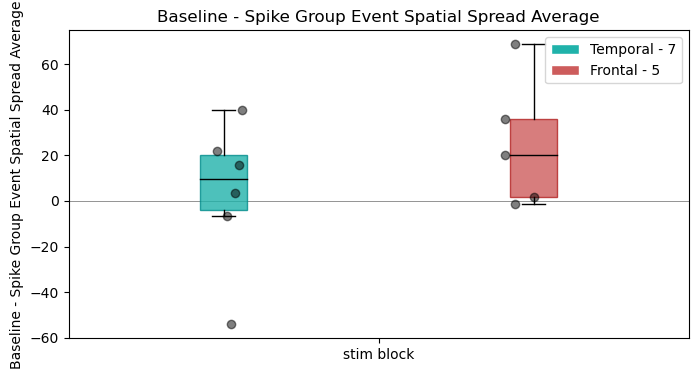

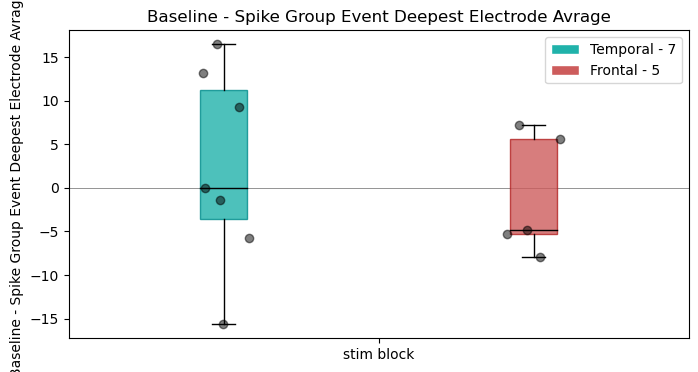

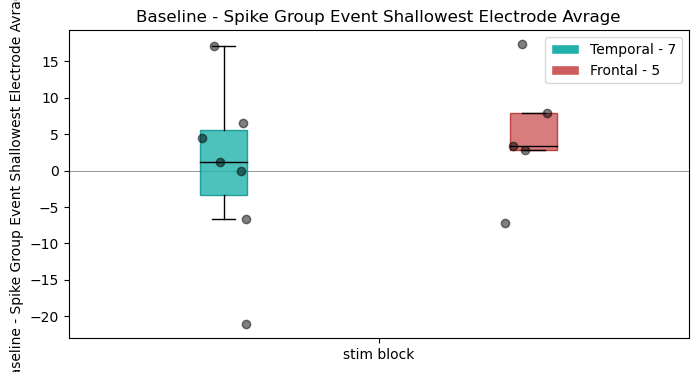

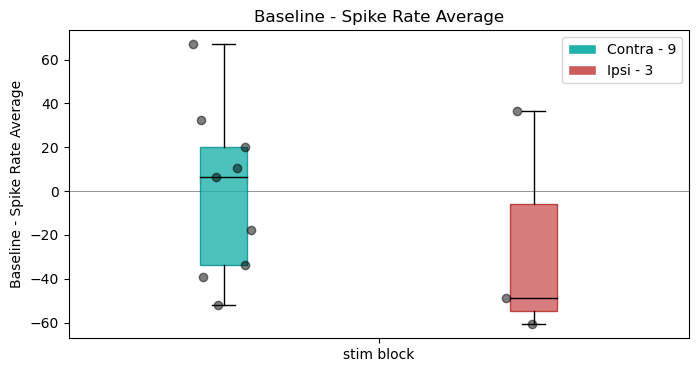

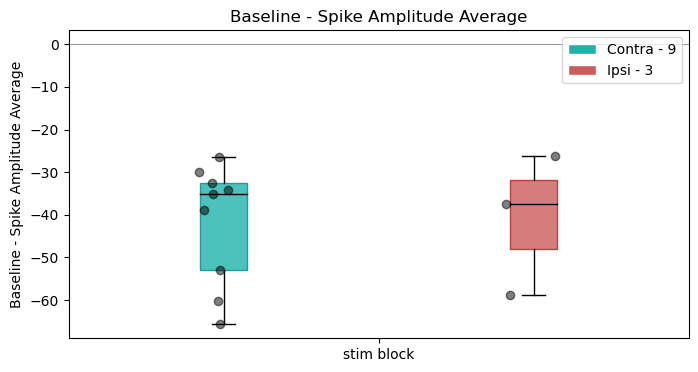

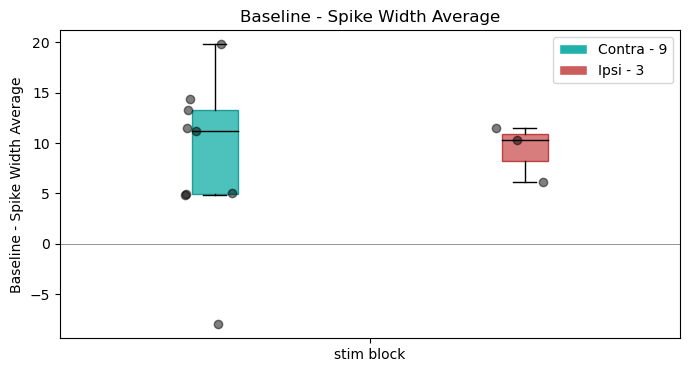

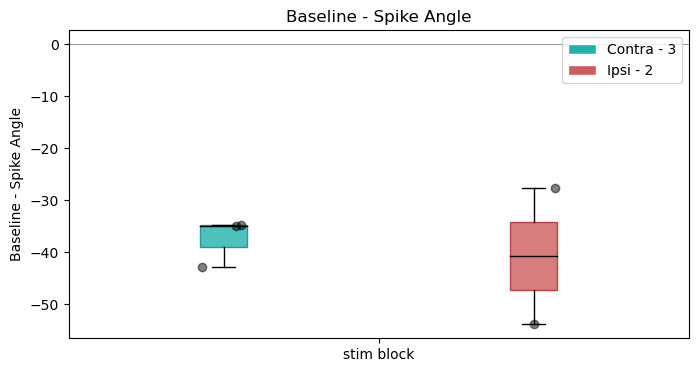

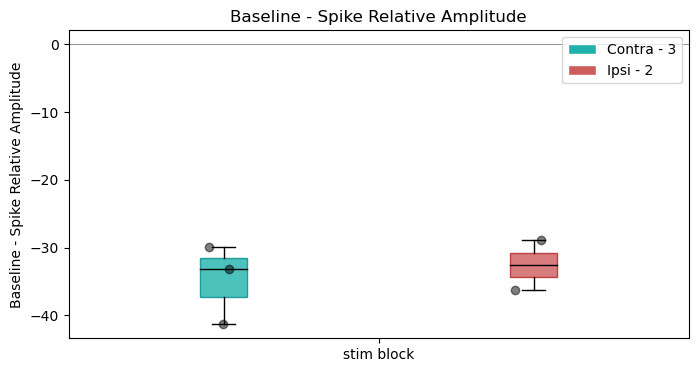

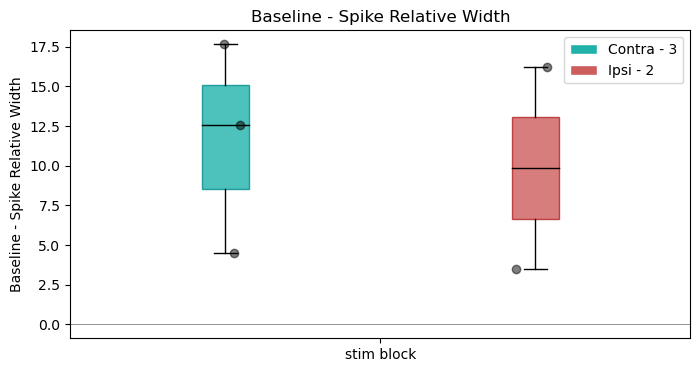

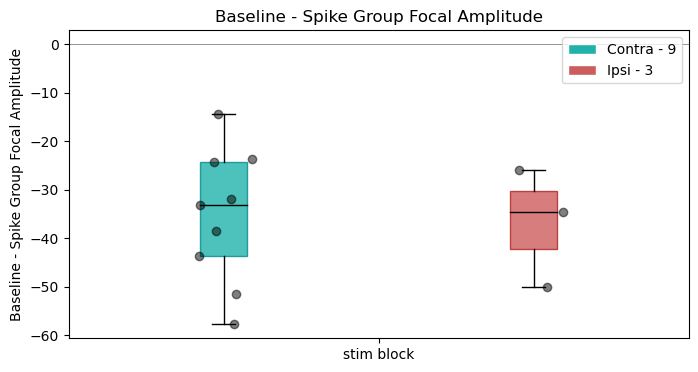

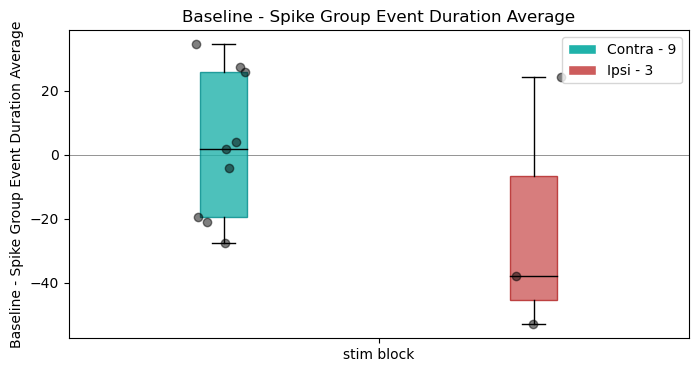

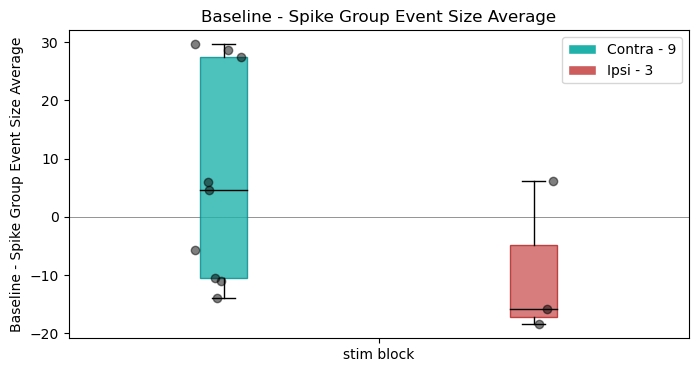

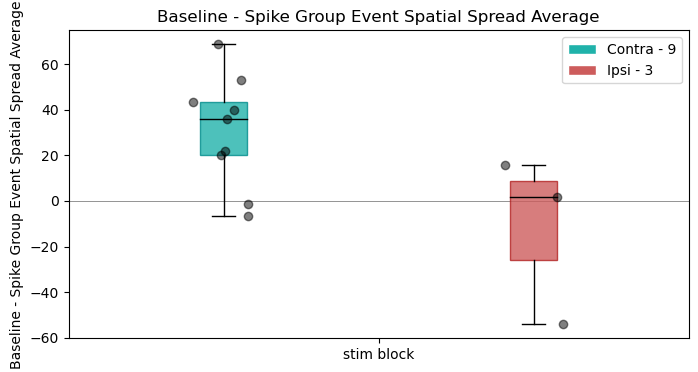

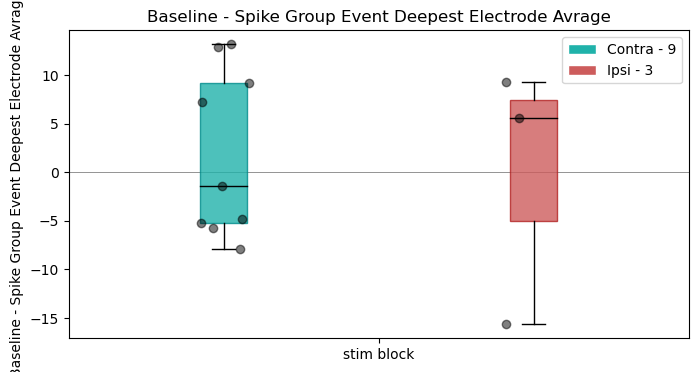

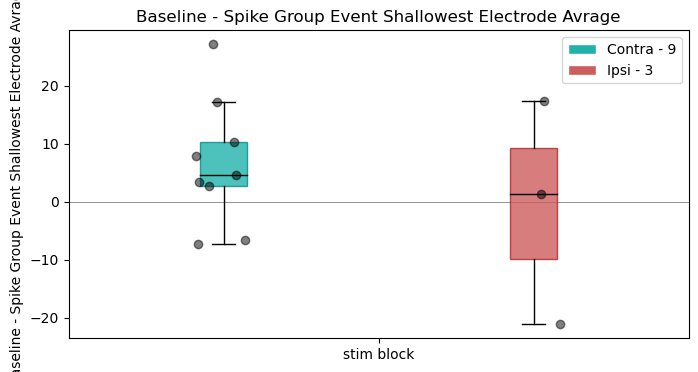

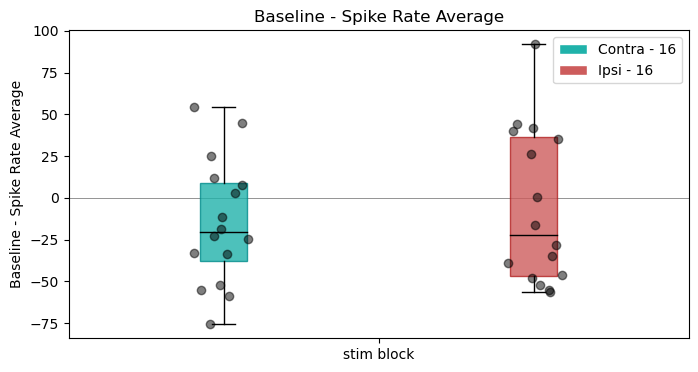

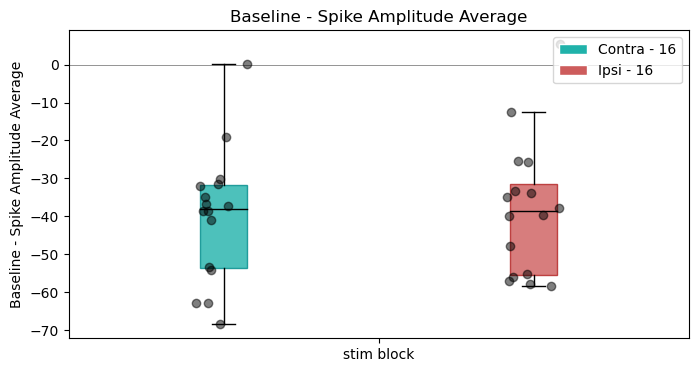

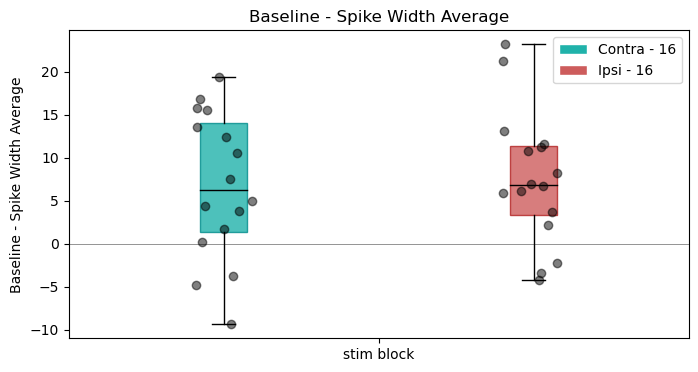

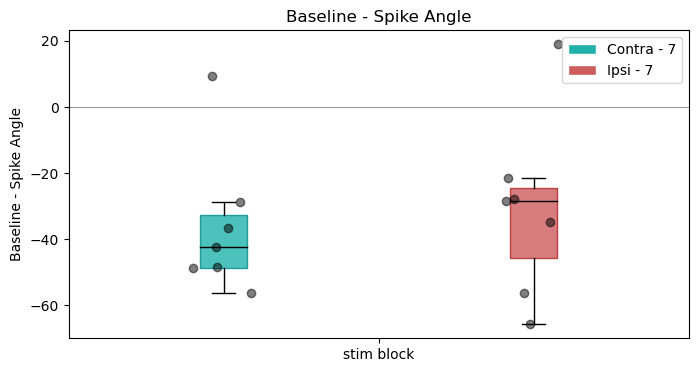

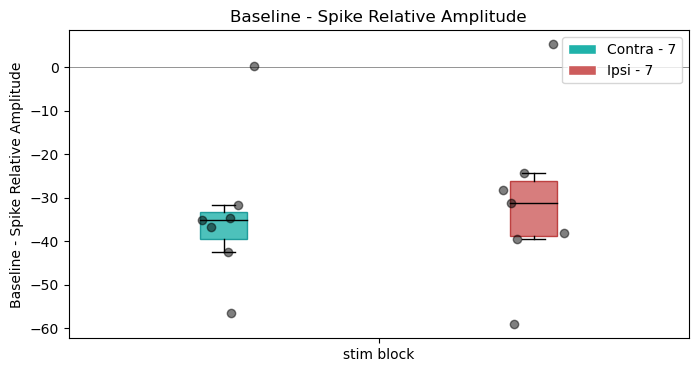

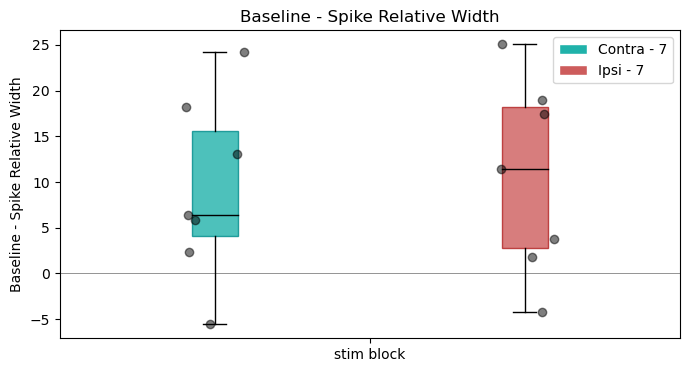

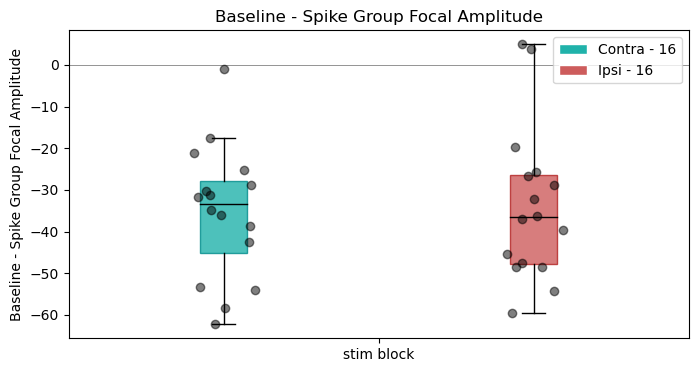

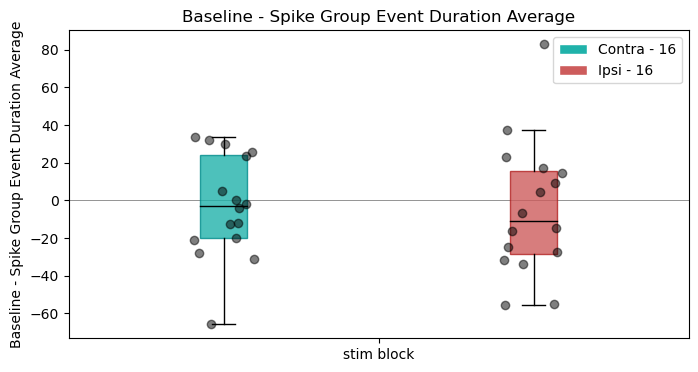

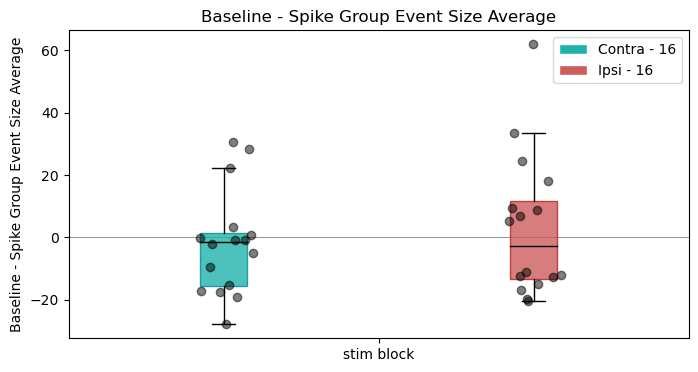

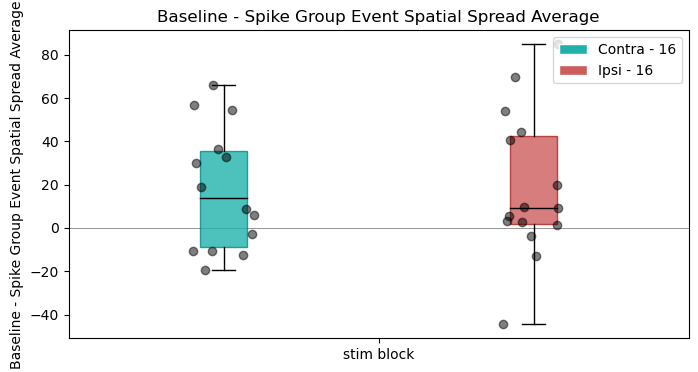

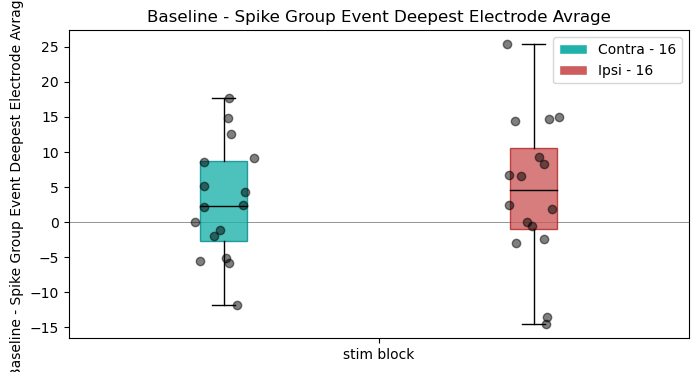

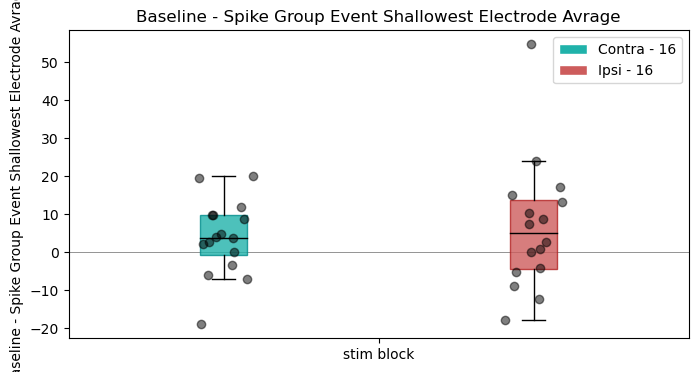

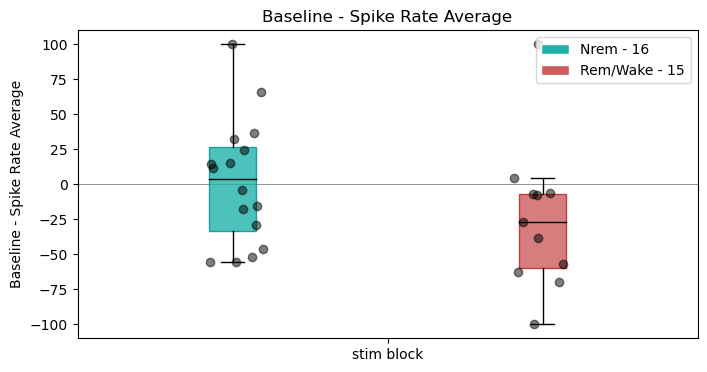

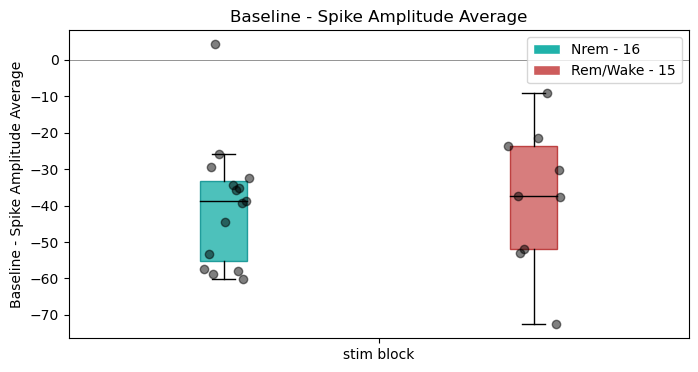

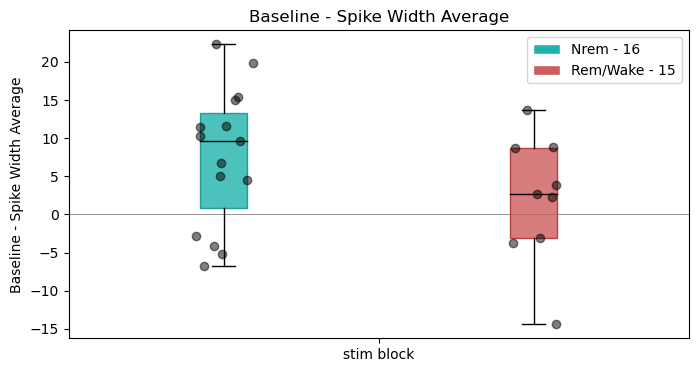

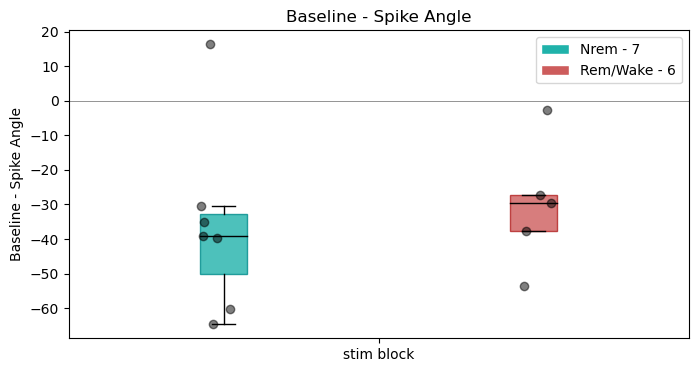

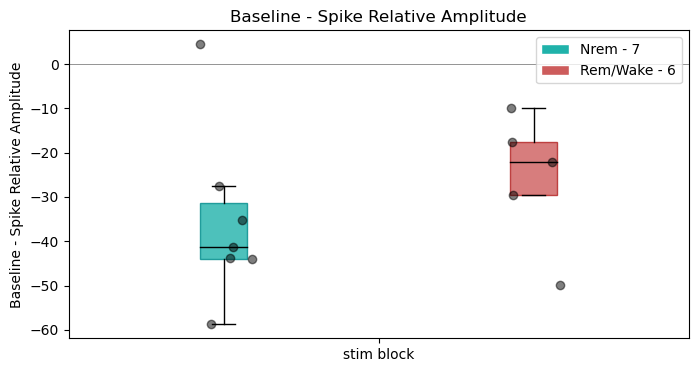

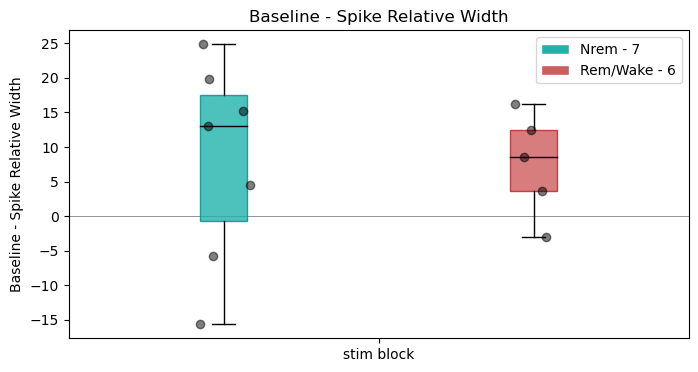

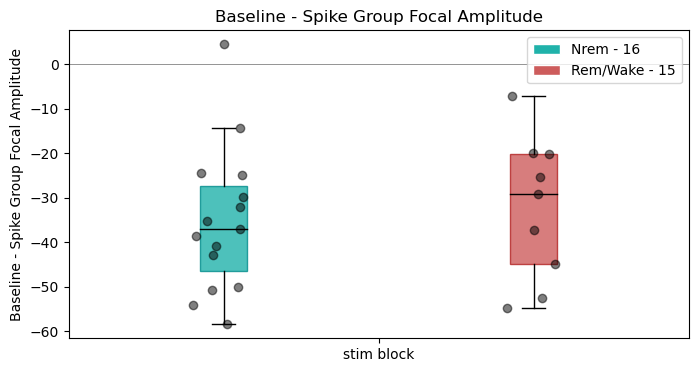

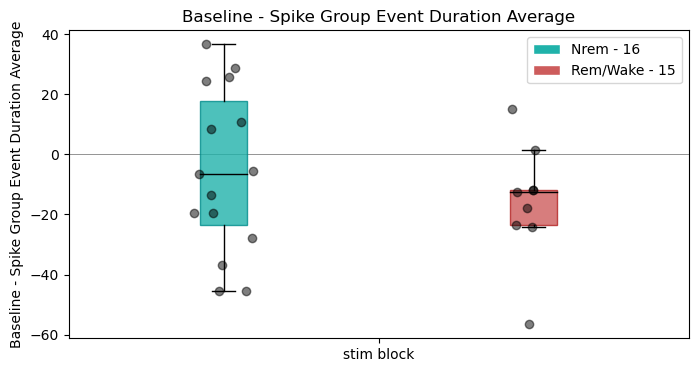

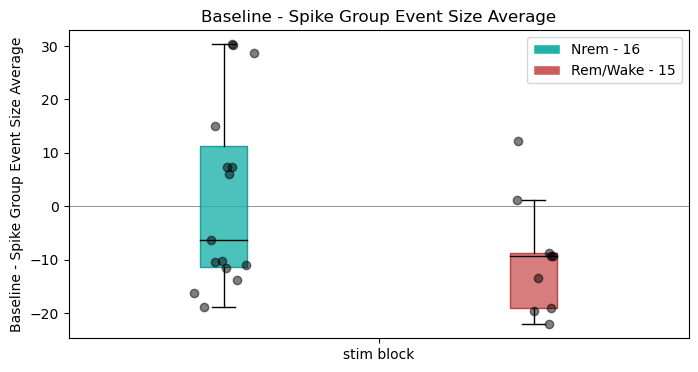

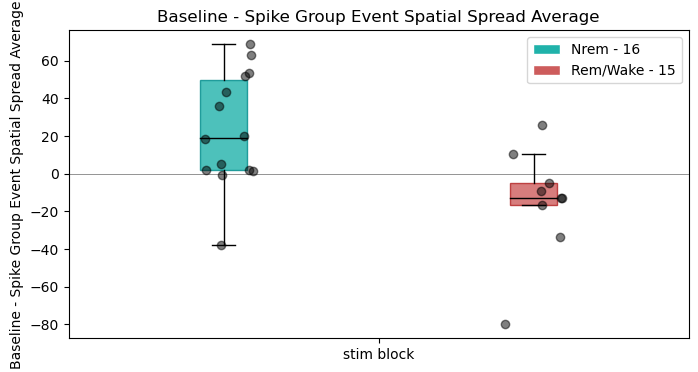

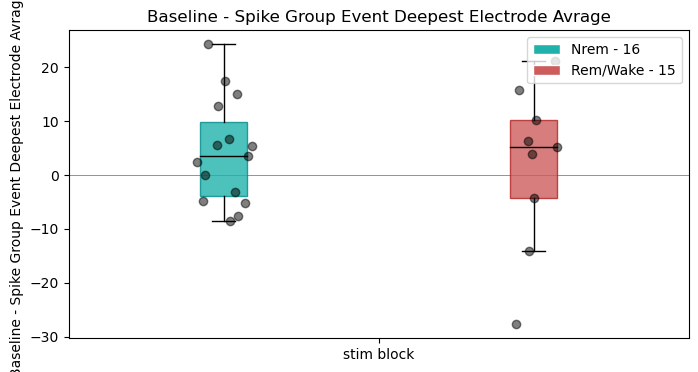

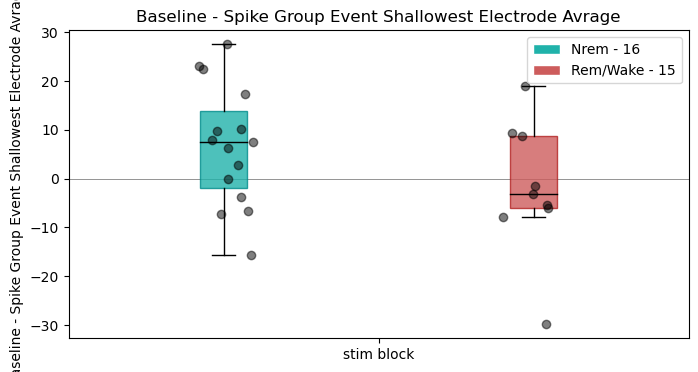

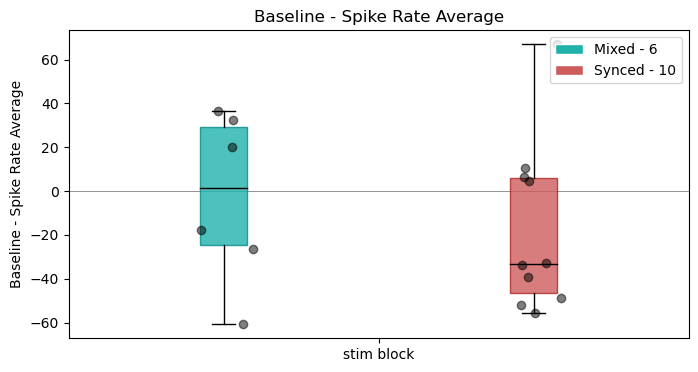

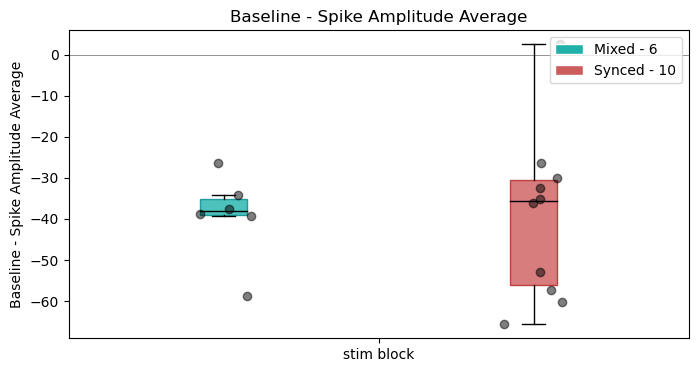

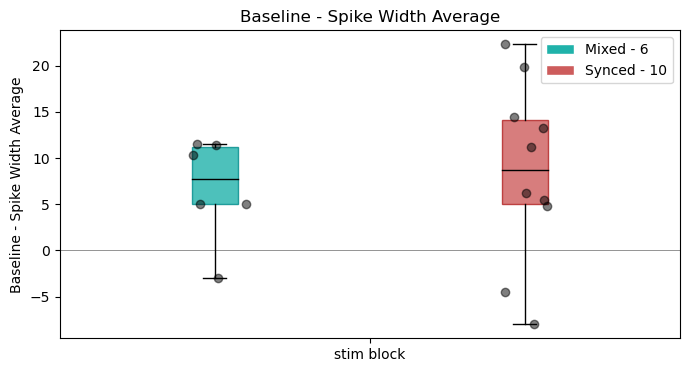

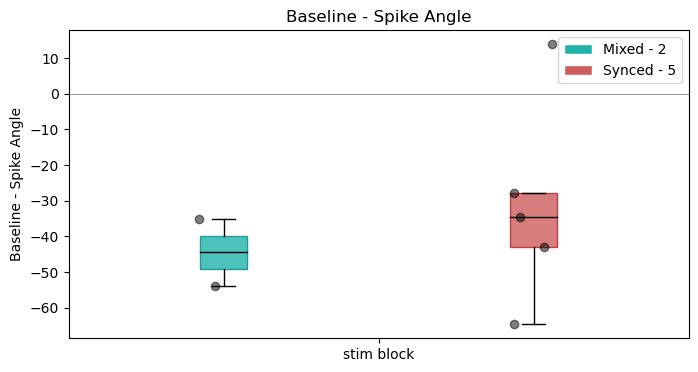

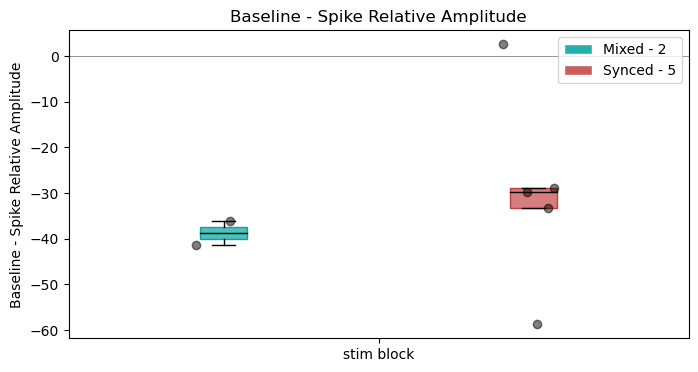

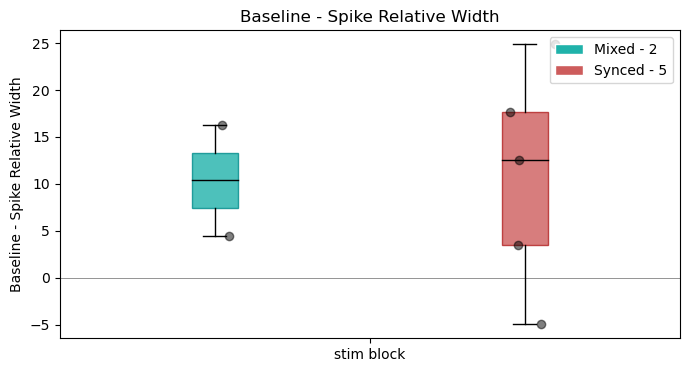

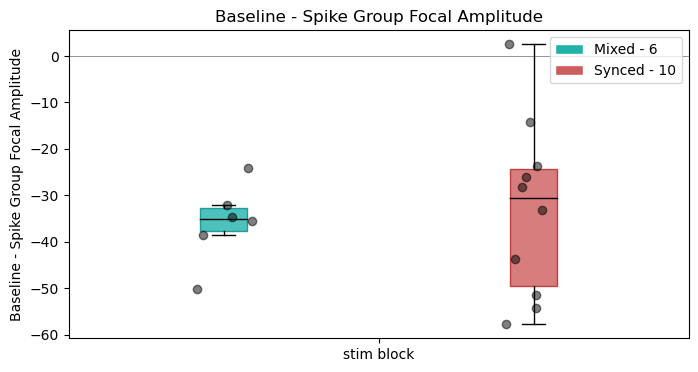

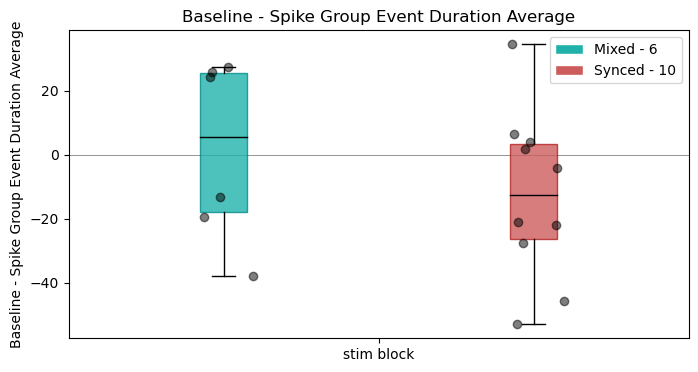

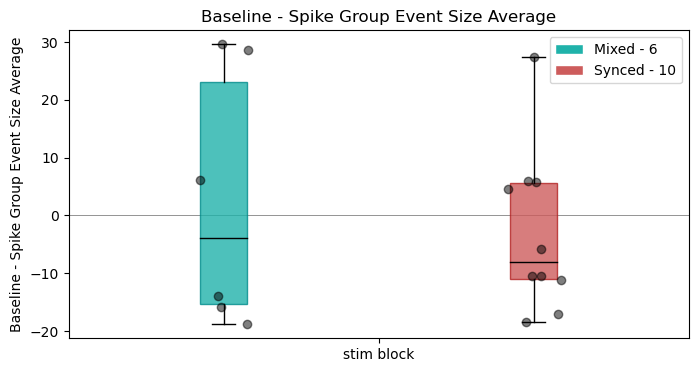

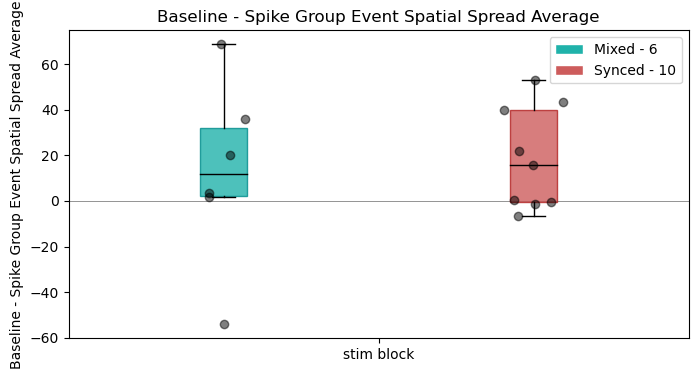

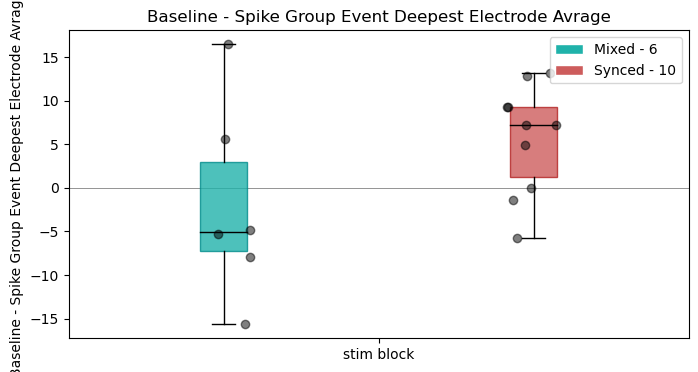

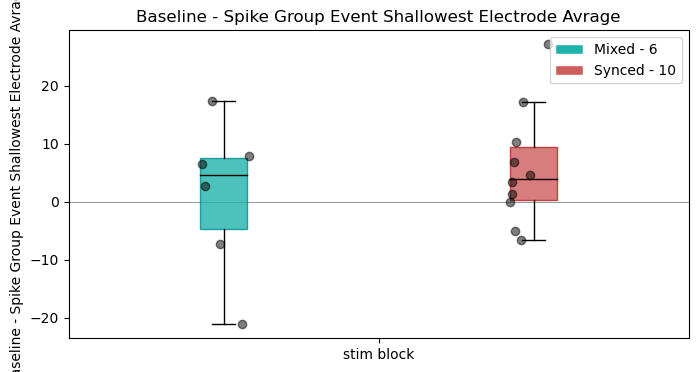

In [19]:
types = {
    'all': {
        'groups': ['All'],
        'seperator_function': all
    },
    'temporal-frontal': {
        'groups': ['temporal', 'frontal'],
        'seperator_function': temporal_frontal_seperator
    },
     'temporal-frontal-soze': {
        'groups': ['temporal', 'frontal'],
        'seperator_function': temporal_frontal_soze
    },
     'contra-ipsi-inter-subject-stimuli': {
        'groups': ['contra', 'ipsi'],
        'seperator_function': contra_ipsi_inter_subjects_seperator
    },
    'contra-ipsi-stimuli': {
        'groups': ['contra', 'ipsi'],
        'seperator_function': contra_ipsi_seperator
    },
    
    'NREM-REMorWake': {
        'groups': ['NREM', 'REM/Wake'],
        'seperator_function': nrem_seperator
    },
    
    'mixed-synced-stimuli': {
        'groups': ['Mixed', 'Synced'],
        'seperator_function': mixed_synced_stimuli_seperator
    }
}
base_line_block_name = 'pause block'

groups_sizes = {}
for _type in types:
    # for compare_to_base_line in [True, False]:
    for compare_to_base_line in [True]:
        results = {}
        groups = types[_type]['groups']
        for feature_index in subjects_stats.keys():
            is_group_feature = GROUP_INDEX <= feature_index <= GROUP_EVENT_SPATIAL_SPREAD_INDEX or feature_index in [GROUP_FOCAL_AMPLITUDE_INDEX]
            prefix = 'group ' if is_group_feature else ''
            suffix = ' big events' if feature_index in [GROUP_EVENT_SPATIAL_SPREAD_INDEX] else ''
            if compare_to_base_line:
                _block_names = block_names[1:]

            else:
                _block_names = block_names[:]
            results[feature_index] = {
                block_name: {group: [] for group in groups} for block_name in _block_names
            }
            groups_sizes[feature_index] = [0, 0]
            for subject in subjects.keys():
                if feature_index >= subjects_blocks[subject][base_line_block_name].shape[1]:
                    print(f'no data for {feature_index} of {subject.name}')
                    continue
                groups, groups_menas, groups_counts = types[_type]['seperator_function'](subjects_blocks[subject], subject, feature_index)        
                for gi, group in enumerate(groups):
                    if is_group_valid(groups_menas[group]):
                        groups_sizes[feature_index][gi] += 1   
                    else:
                        pass

                    group_data = groups_menas[group]
                    for block_name in _block_names:
                        block_data = group_data.get(prefix+block_name+suffix)
                        if block_data is None:
                            print(f'Skipping block {block_name} for subject {subject.name}')
                            continue
                        base_line_data = group_data[prefix+base_line_block_name+suffix]
                        if feature_index == TIMESTAMP_INDEX:
                            block_data = groups_counts[group][block_name] / subject_block_durations[subject][block_name]
                            base_line_data = groups_counts[group][base_line_block_name] / subject_block_durations[subject][base_line_block_name]
                        
                        if np.isnan(block_data):
                            continue
                            
                        if compare_to_base_line:
                            results[feature_index][block_name][group].append(
                                putils.baseline_diff(base_line_data, block_data)
                            )
                        else:
                            results[feature_index][block_name][group].append(
                               block_data
                            )

        subject = Subject(STIMULI_PROJECT_INTERSUBJECTS_SUBJECT_NAME, True)
        path = os.path.join(subject.paths.subject_stimuli_effects_plots_dir_path, _type)
        if not os.path.exists(path):
            os.makedirs(path)

        for feature_index, stats in results.items():
            plotting.create_box_plot_for_stimuli(
                figure_path=path,
                groups_size=groups_sizes[feature_index],
                data_channels=results[feature_index],
                feature_name=('Baseline - ' if compare_to_base_line else 'Raw - ') + feature_id_to_title[feature_index],
            )